In [1]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import pickle
import emcee
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import numpy as np
from astropy.table import Table, QTable, hstack, vstack
import iminuit
from iminuit import Minuit
import corner

#module from my personnal github
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import CL_WL_miscentering as mis
import CL_WL_DATAOPS_make_profile as prf
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_WL_fit_cluster_mass as fit
import CL_Mass_richness_relation as mr

sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/DESC_note/Notebooks/')
import analysis_Mass_observable_relation as analysis

import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl
from astropy.cosmology import FlatLambdaCDM
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

In [2]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

# Load data

In [3]:
profile_BPZ = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/p_RedMapper_clusters/paper_dc2_galaxy_cluster_mass/data_DS/Richness_cosmodc2_flex_BPZ/individual_epsilon_shape_BPZ_z_all_bins.pkl')
profile_flex = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/p_RedMapper_clusters/paper_dc2_galaxy_cluster_mass/data_DS/Richness_cosmodc2_flex_BPZ/individual_epsilon_shape_flex_z_all_bins.pkl')
profile_true = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/p_RedMapper_clusters/paper_dc2_galaxy_cluster_mass/data_DS/Richness_cosmodc2_flex_BPZ/individual_epsilon_shape_true_z_all_bins.pkl')

In [4]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin

# Fiducial

In [5]:
%load_ext autoreload
%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/DESC_note/Notebooks/')
import DN1_binned_mass_richness_relation as fiducial

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
fiducial_constraint = fiducial.constrain_fiducial(used_cluster_id_list = np.array(profile_true['cluster_id']), low_M_cut = 3e13)

100%|██████████| 100/100 [00:11<00:00,  8.69it/s]


# WL mass

## Estimating shear profile

In [7]:
profile_true_stack = prf.stacked_profile(profile = profile_true,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)
covariance_true_stack = prf.bootstrap_covariance(profile = profile_true,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    n_boot = 400,
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


In [8]:
profile_BPZ_stack = prf.stacked_profile(profile = profile_BPZ,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)
covariance_BPZ_stack = prf.bootstrap_covariance(profile = profile_BPZ,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    n_boot = 400,
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

In [9]:
profile_flex_stack = prf.stacked_profile(profile = profile_flex,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

covariance_flex_stack = prf.bootstrap_covariance(profile = profile_flex,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    n_boot = 400,
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

## Fit halo mass

In [10]:
down = 1
up = 5.5
a = 1.53 + 0.25
b = 0.38 + 0.10
true = fit.fit_WL_cluster_mass(profile = profile_true_stack, covariance = covariance_true_stack, a = a, b = b, rmax = up, two_halo_term = False, fix_c = True)
BPZ = fit.fit_WL_cluster_mass(profile = profile_BPZ_stack, covariance = covariance_BPZ_stack, a = a, b = b, rmax = up, two_halo_term = False, fix_c = True)
flex = fit.fit_WL_cluster_mass(profile = profile_flex_stack, covariance = covariance_flex_stack,a = a, b = b, rmax = up, two_halo_term = False, fix_c = True)

In [11]:
fits = [true, BPZ,flex]
text = ['true z', 'BPZ','FlexZBoost']

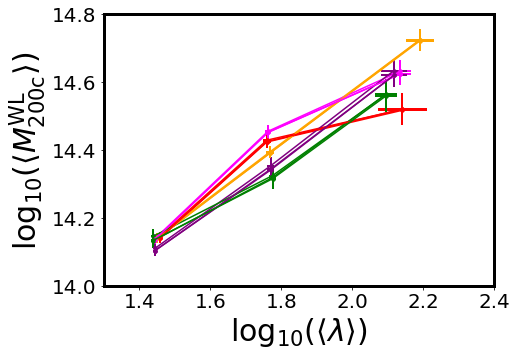

In [12]:
plt.rcParams['axes.linewidth'] = 3
plt.figure(figsize = (7,5))
color_z = ['orange','red','magenta','purple','green','cyan','blue','black']
x = np.linspace(1,3,100)
y = 0.7*x + 13.2
for i, f in enumerate(fits):
    for k, z_bin in enumerate(Z_bin):
            mask = (f['z_mean'] > z_bin[0])*(f['z_mean'] < z_bin[1])
            f_cut = Table(f)[mask]
            a_t = 1./(1 + f_cut['z_mean'])
            richness = f_cut['obs_mean']
            richness_err = f_cut['obs_rms']
            logm200w = f_cut['logm200_w']
            logm200w_err = f_cut['logm200_w_err']
            #axs[i_fits[i],j_fits[i]].text(1.5, 14.7, text[i], fontsize = 30)
            plt.errorbar(np.log10(richness),logm200w,logm200w_err, richness_err/(np.log(10)*richness),
                    marker = '.', 
                    elinewidth = 2, capsize = 0, markersize = 7, c = color_z[k],
                        markerfacecolor = None)
    plt.xlim(1.3,2.4)
    plt.ylim(14,14.8)
    plt.tick_params(axis='both', which = 'major', labelsize= 20)
    #plt.legend(frameon = False, fontsize = 20, loc = 'lower right')
    #axs[i_fits[i],j_fits[i]].grid('True')
    plt.xlabel(r'$\log_{10}(\langle \lambda \rangle)$', fontsize = 30)
    plt.ylabel(r'$\log_{10}(\langle M_{\rm 200c}^{\rm WL}\rangle)$', fontsize = 30)
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/est_wl_mass.png', bbox_inches='tight', dpi=300)

# Likelihood for mass-richness relation

In [13]:
def lnL(theta, m200c_mean, m200c_err_mean, richness_mean, z_mean):
    return mr.lnL_WL_binned(theta, m200c_mean, m200c_err_mean, richness_mean, z_mean, z0, richness0)

In [14]:
z0 = analysis.z0
richness0 = analysis.richness0
initial_binned = [14.1,-0,.75]
npath = 100
ndim=3
nwalkers = 800
pos_binned = initial_binned + 0.01 * np.random.randn(nwalkers, len(initial_binned))
label = ['true','BPZ','Flex']
sampler_list = {name : 0 for name in label}
for i,fit_true in enumerate(fits):
    m200c_mean = 10**np.array(fit_true['logm200_w'])
    m200c_err_mean =np.array(fit_true['logm200_w_err'])*np.log(10)*m200c_mean
    richness_mean = np.array(fit_true['obs_mean'])
    z_mean = np.array(fit_true['z_mean'])
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnL, args = (m200c_mean, m200c_err_mean, richness_mean, z_mean))
    sampler.run_mcmc(pos_binned, npath,progress=True)
    sampler_wl = sampler.get_chain(discard = 0, flat = True)
    sampler_list[label[i]] = sampler_wl

100%|██████████| 100/100 [00:04<00:00, 23.41it/s]


In [15]:
label_plot = [ r'WL BPZ photometric',r'WL FleXZBoost photometric',r'WL true redshift',]

In [16]:
sampler_tot = [ sampler_list['BPZ'],sampler_list['Flex'], sampler_list['true'],]

In [17]:
a = len(sampler_list['true'])
middle = np.mean(sampler_list['true'][50000:a-1], axis = 0)
std = np.std(sampler_list['true'][50000:a-1], axis = 0)
range_corner_plot = [(middle[i]- 3*std[i], middle[i]+ 3*std[i]) for i in range(3)]

## Corner plot

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


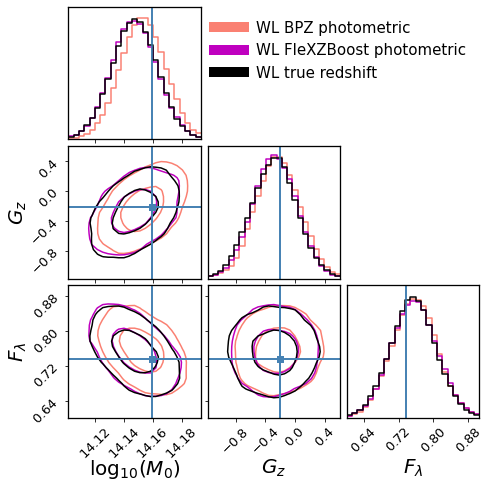

In [19]:
plt.rcParams['axes.linewidth'] = 1.3
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
truth = [14.162, -0.23, 0.8]
bins = 25
labels = [r'$\log_{10}(M_{0})$', r'$G_z$',r'$F_\lambda$']
c = ['salmon','m','k','orange','cyan']
fill_contours = [False, False, False,False,  True]
fig, axs = plt.subplots(len(labels), len(labels), figsize = (7,7))
for i, name in enumerate(label_plot):
    axs[0,2].plot([],[], c[i], linewidth = 10, label = label_plot[i])

for i,sample in enumerate(sampler_tot):
    a = len(sample)
    sample_cut = sample[50000:a-1]
    fig = corner.corner(
    sample_cut,
    bins=bins, levels=(sigma1, sigma2),
    range = range_corner_plot,
    truths = fiducial_constraint,
    fig = fig,
    color = c[i],
    smooth1d=True,smooth=True,plot_datapoints=False,
    fill_contours=fill_contours[i], labels = labels,            
    label_kwargs={"fontsize": 20},
    use_math_text=True,
    show_title = True,
    plot_density=False,
    max_n_ticks = 5);
    
for i in range(len(labels)):
    for j in range(len(labels)):
        axs[i,j].tick_params(axis='both', which = 'major', labelsize= 13)
        axs[i,j].legend(frameon = False, fontsize = 15)

plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/BPZ.png', bbox_inches='tight', dpi=300)